# Number Recognition

This notebook will work on a popular handwritten digits datababase called MNIST.

**Main goals are**: 

    - Being able to format input data
    - Retreiving metrics about original dataset
    - Choosing a model based on our problem
    - Training the model properly
    - Check model performances

In [6]:
# Fetching data and first raw visualization using embded scikit-learn functionality
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

To prevent you from long and unecessary reloading please **do not execute above** cell multiple times, only one should do the trick

In [13]:
# Displaying single raw feature
print(X[0])
y[0]

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

'5'

### Bellow we expose some data problems regarding shape and display requirements.
Here each sample is composed of a **784 vector** array and represent a **28 by 28** image

```Note : The initial format is really helpful when it comes to ML but not really representative for human visualization```

In [19]:
import numpy as np
np.shape(X[0])

(784,)

Should display a : 5


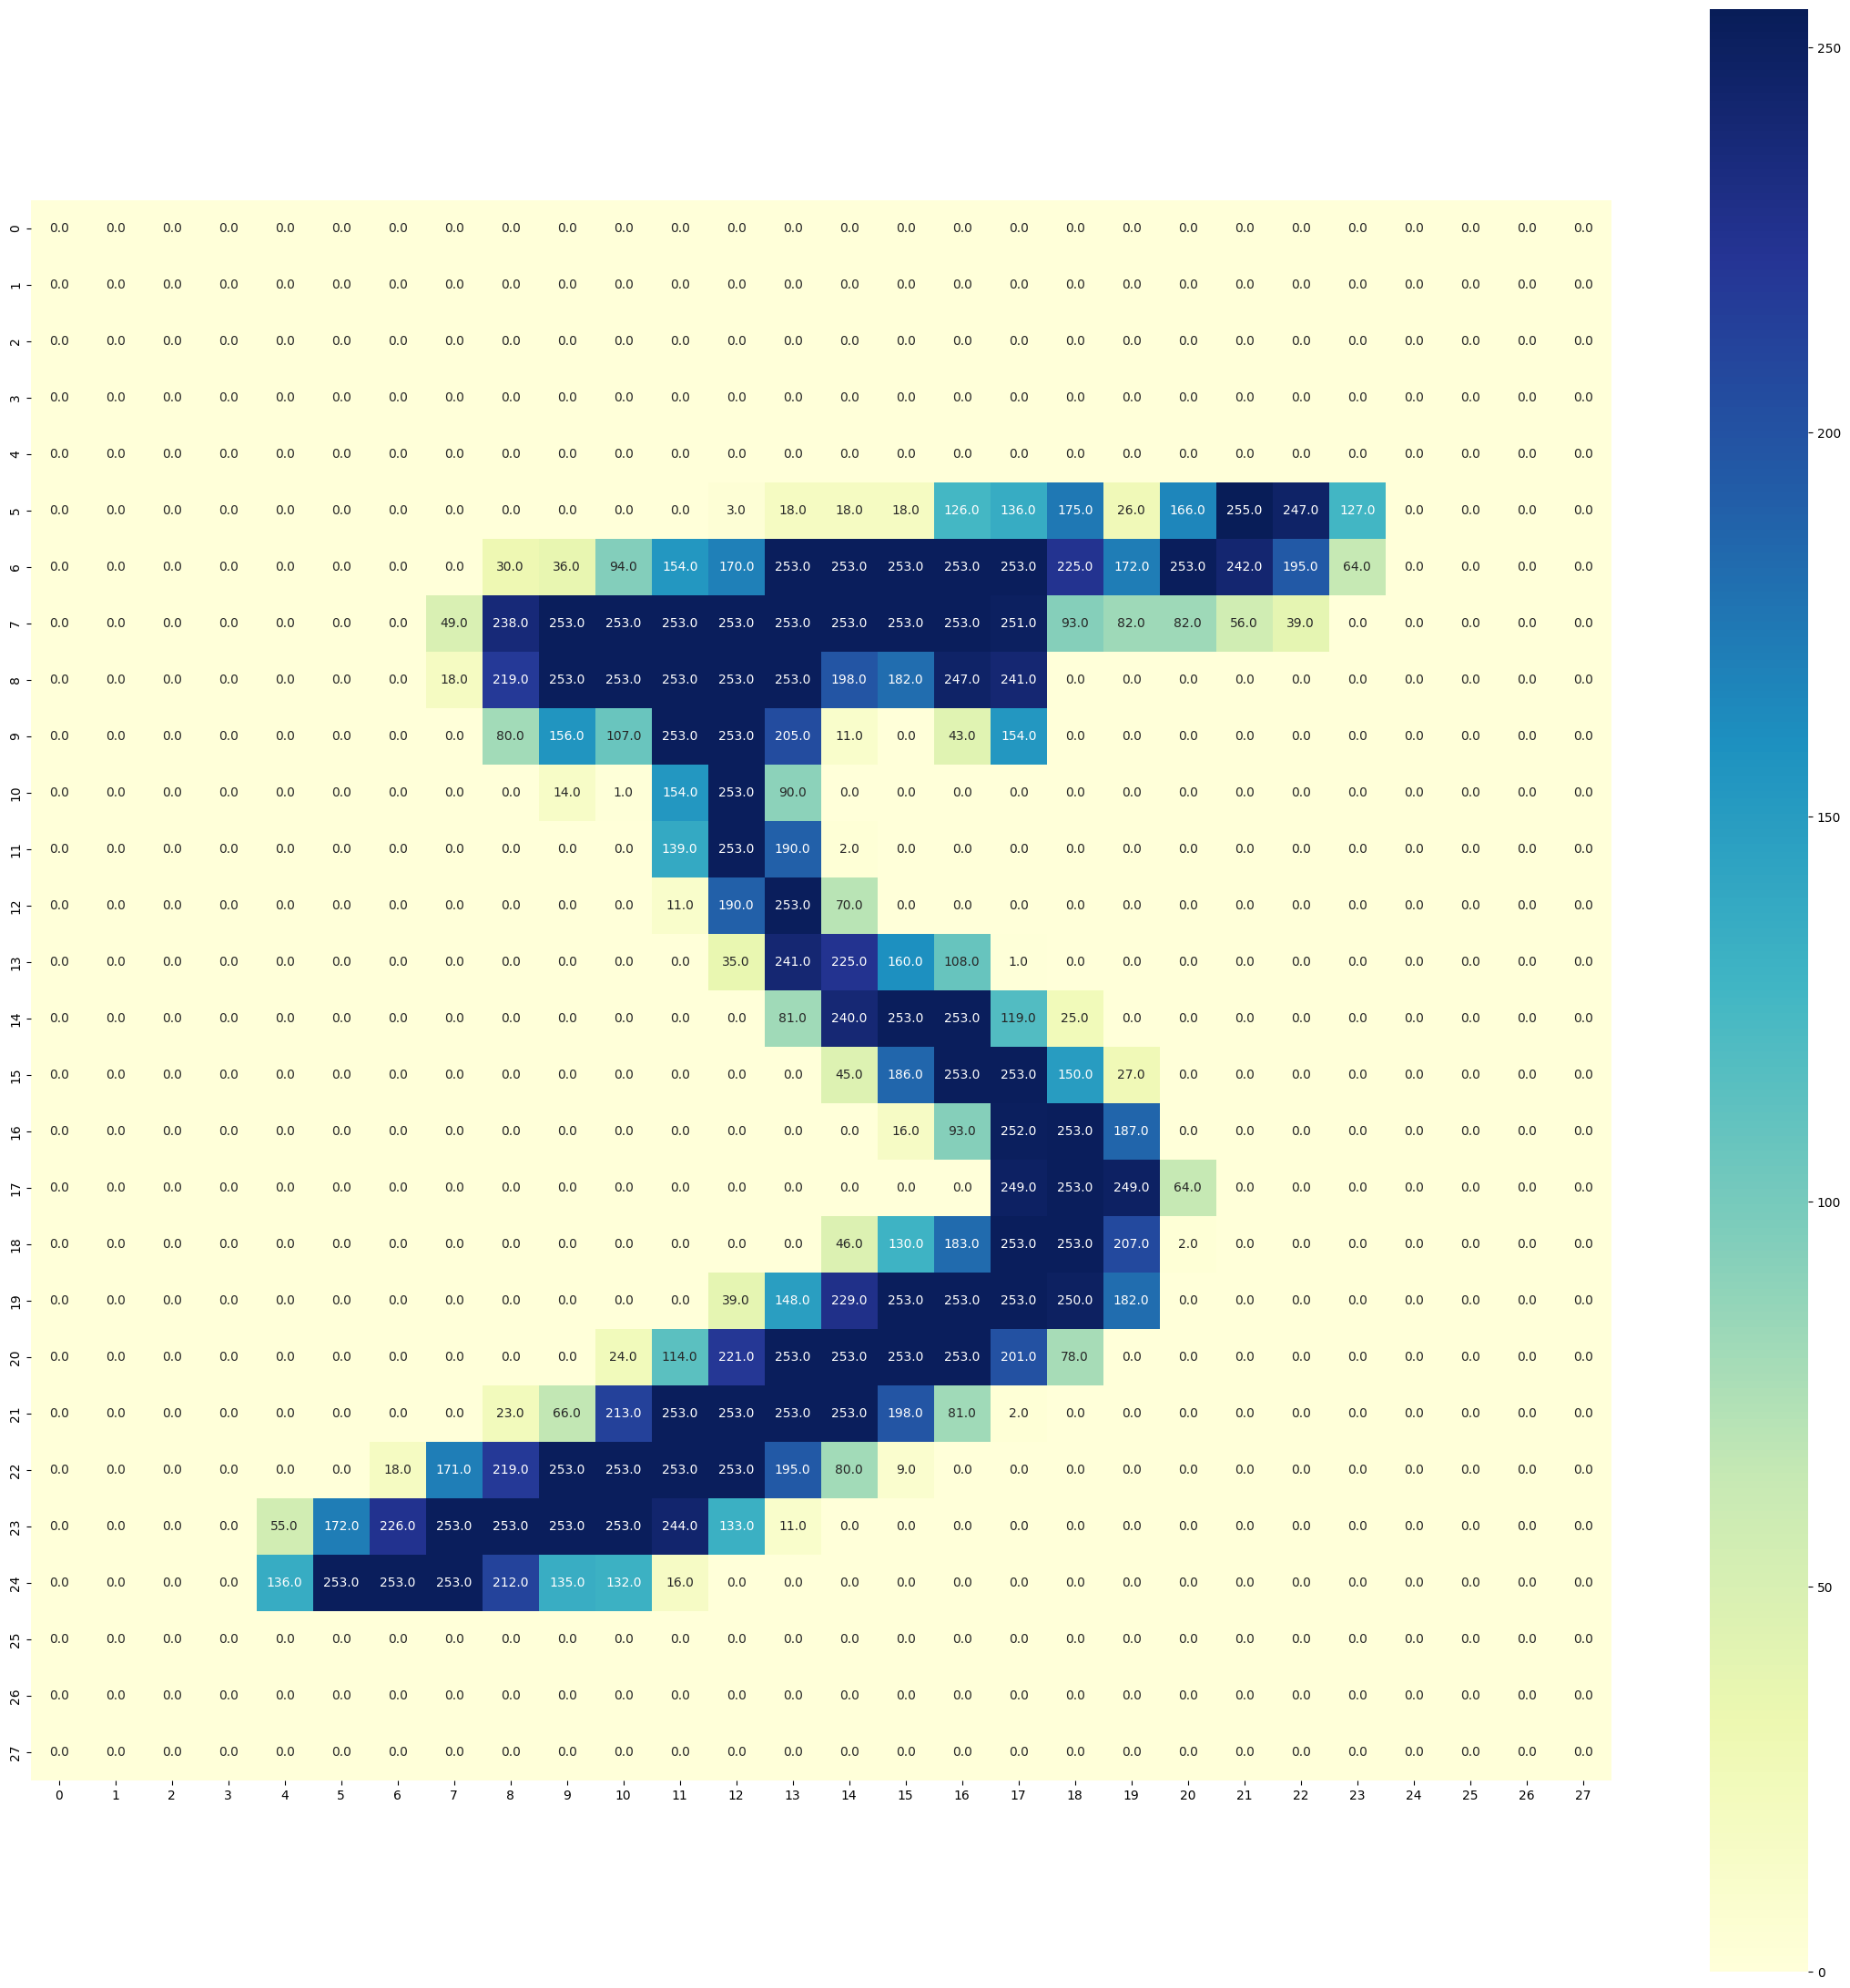

In [30]:
# Using a nice ploting lib
import matplotlib.pyplot as plt

import seaborn as sns

image = X[0].reshape(28,28)
label = y[0]

print("Should display a : " + label)
f, ax = plt.subplots(figsize=(28, 28))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

# Bellow we can have a closer view to what the computer will use as data

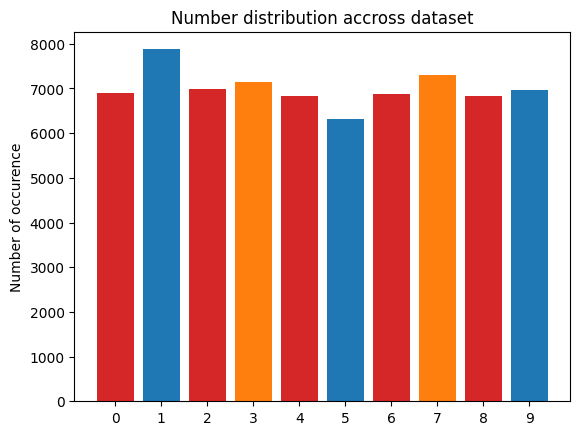

In [38]:
from matplotlib.pyplot import bar

unique, counts = np.unique(y, return_counts=True)

fig, ax = plt.subplots()

bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(unique, counts, color=bar_colors)

ax.set_ylabel('Number of occurence')
ax.set_title('Number distribution accross dataset')

plt.show()

Looking at above plot we can confirm that there is not much data imbalance. Which is a really good point because this will help us simplify rating models because we won't have a baised prediction induced by lake of training on certain samples.

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

max_diff_train = ((counts_train.max() - counts_train.min()) / counts_test.sum()) * 100
max_diff_test = ((counts_test.max() - counts_test.min()) / counts_test.sum()) * 100

print("Maximum gap on train set : "+ str(max_diff_train) +" %")
print("Maximum gap on test set : "+ str(max_diff_test) +" %")
print("The distribution accross datasets (even after split) stay consistent")

Maximum gap on train set : 4.372294372294372 %
Maximum gap on test set : 2.3982683982683985 %
The distribution accross datasets (even after split) stay consistent


# Starting machine learning on previously reviewed data

From now we will focuse more on building algorithms that enable us to predict which number is contained in a image.

This will include : 
 - Processing data
 - Comparing models
 - Assesing results

In [74]:
# First of all we will use a DummyClassifier to get an idea of what a uncorrelated model looks like
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using randomly generated answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using only most frequent number as answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using uniform distribution answer we get " + str(ac) + "% Accuracy")

Using randomly generated answer we get 10.48% Accuracy
Using only most frequent number as answer we get 11.4% Accuracy
Using uniform distribution answer we get 9.87% Accuracy


```As we can see, an uncorrelated model will have around 10% accuracy wich is pretty logical beacause complete random is also around 1/10 chance of getting good prediction```

In [88]:
# As target is a non continuous value it's more appropriated to look for classifier models rather than regressors
# Trying basic model KNN
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
ac = round(knn_clf.score(X_test, y_test) * 100, 2)
print("Base knn accuracy is around " + str(ac) + "% Accuracy")

Base knn accuracy is around 96.91% Accuracy


This accuracy could be improved using multiples factors : 
 - Unappropriate data structure
 - No parameter adaptation/tunning
 - Accuracy evaluation not representative

In [84]:
# Let's try preprocess data to extract more feature from our samples data
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaled_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

scaled_pipeline.fit(X_train, y_train)
ac = round(scaled_pipeline.score(X_test, y_test) * 100, 2)
print("Scaled data upon knn accuracy is around " + str(ac) + "% Accuracy")

Scaled data upon knn accuracy is around 94.22% Accuracy


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

scaled_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {'classifier__n_neighbors': [1, 2, 5, 10, 18]}

model = GridSearchCV(
    scaled_pipeline,
    param_grid=param_grid
).fit(X, y)

ac = round(model.score(X_test, y_test) * 100, 2)
print("Scaled data upon knn accuracy is around " + str(ac) + "% Accuracy")
model.best_params_

NameError: name 'KNeighborsClassifier' is not defined

In [83]:
model.best_params_

{'classifier__n_neighbors': 5}

We find out that best value is default one **(n_neighbors=5)** so we could not get any furhter using this parameter either we would risk overffiting

```For now let's try to improve accuracy assesment```

In [1]:
from sklearn.model_selection import cross_validate

optimized_pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

cv_results = cross_validate(optimized_pipeline, X, y, cv=10)
cv_results

NameError: name 'Pipeline' is not defined

In [86]:
accuracy = cv_results["test_score"].mean() * 100
print("Cross validate + scaled data +  optimized params = " + str(accuracy) + "% Accuracy")

0.9454428571428573